# MRNet - explatory data analysis (EDA)

## Background

---

In the paper [Deep-learning-assisted diagnosis for knee magnetic resonance imaging: Development and retrospective validation of MRNet](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1002699), the [Stanford ML Group](https://stanfordmlgroup.github.io/) developed an algorithm to predict abnormalities in knee MRI exams, and measured the clinical utility of providing the algorithm’s predictions to radiologists and surgeons during interpretation.

They developed a deep learning model for detecting:

- **general abnormalities**

- **anterior cruciate ligament (ACL)**

- **meniscal tears**

## MRNet Dataset description

---

The **dataset (~5.7G)** was released along with the publication of the paper. You can download it by agreeing to the Research Use Agreement and submitting your details on the [MRNet Competition](https://stanfordmlgroup.github.io/competitions/mrnet/) page.

It consists of **1,370 knee MRI exams**, containing:

- **1,104 (80.6%) abnormal exams**

- **319 (23.3%) ACL tears**

- **508 (37.1%) meniscal tears**

The dataset is split into:

- **training set (1,130 exams, 1,088 patients)**

- **validation set (120 exams, 111 patients)** - called _tuning set_ in the paper

- **hidden test set (120 exams, 113 patients)** - called _validation set_ in the paper

The hidden test set is _not publically available_ and is used for scoring models submitted for the competition.

N.B.

- [Stratified random sampling](https://en.wikipedia.org/wiki/Stratified_sampling) was used to ensure _at least 50 positive examples_ of abnormal, ACL tear and meniscal tear were preset in each set.

- All exams from each parient were put in the same split.

- In the paper, an external validation was performed on a [pubclically available data](http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/).

## Dataset structure

---

First, let's inspect the content within the dataset.

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from glob import glob

In [2]:
data_dir = 'data/MRNet-v1.0'

!ls -lh $data_dir

total 36K
drwxr-xr-x 6 misao 725066026  192 Jun 17 17:40 train
-rw-r--r-- 1 misao 725066026 7.8K Nov 25  2018 train-abnormal.csv
-rw-r--r-- 1 misao 725066026 7.8K Nov 25  2018 train-acl.csv
-rw-r--r-- 1 misao 725066026 7.8K Nov 25  2018 train-meniscus.csv
drwxr-xr-x 6 misao 725066026  192 Jun 17 17:39 valid
-rw-r--r-- 1 misao 725066026  840 Nov 25  2018 valid-abnormal.csv
-rw-r--r-- 1 misao 725066026  840 Nov 25  2018 valid-acl.csv
-rw-r--r-- 1 misao 725066026  840 Nov 25  2018 valid-meniscus.csv


The dataset is made up of `train` and `valid` directories, as well as `csv` files for the diagnoses of the three conditions we're interested in.

First, I'm going to focus on the `train` and `valid` directories, which contain MRI scan images.

## MRI scan images

---

In [3]:
train_dir = f'{data_dir}/train'
valid_dir = f'{data_dir}/valid'

!ls -lh $train_dir $valid_dir

data/MRNet-v1.0/train:
total 0
drwxr-xr-x 1133 misao 725066026 36K Jun 17 17:39 axial
drwxr-xr-x 1133 misao 725066026 36K Jun 17 17:40 coronal
drwxr-xr-x 1133 misao 725066026 36K Jun 17 17:40 sagittal

data/MRNet-v1.0/valid:
total 0
drwxr-xr-x 122 misao 725066026 3.9K Feb  5 04:44 axial
drwxr-xr-x 122 misao 725066026 3.9K Feb  5 04:45 coronal
drwxr-xr-x 122 misao 725066026 3.9K Feb  5 04:46 sagittal


In [4]:
print('Check disk usage\n')
!du -h $train_dir $valid_dir

Check disk usage

2.4G	data/MRNet-v1.0/train/axial
2.2G	data/MRNet-v1.0/train/sagittal
2.1G	data/MRNet-v1.0/train/coronal
6.6G	data/MRNet-v1.0/train
258M	data/MRNet-v1.0/valid/axial
230M	data/MRNet-v1.0/valid/sagittal
222M	data/MRNet-v1.0/valid/coronal
709M	data/MRNet-v1.0/valid


In [5]:
print(f'First 5 items in {train_dir}/axial/\n')
!ls $train_dir/axial | head -5

First 5 items in data/MRNet-v1.0/train/axial/

0000.npy
0001.npy
0002.npy
0003.npy
0004.npy


In [6]:
planes = ['axial', 'coronal', 'sagittal']
datasets = {'train': train_dir, 'valid': valid_dir}

for dataset, path in datasets.items():
    print(f'\nNumber of exams in {dataset} set:')
    for plane in planes:
        print(plane, len(glob(f'{path}/{plane}/*.npy')))


Number of exams in train set:
axial 1130
coronal 1130
sagittal 1130

Number of exams in valid set:
axial 120
coronal 120
sagittal 120


So far, we've found that the `train` and `valid` sets are further divided into three planes - `axial`, `sagittal` and `coronal` - and each exam series is provided as a `npy` file.

We have also validated that the `train` and `valid` sets contain 1,130 and 120 exams, respectively.

Let's open a couple of them.

In [7]:
train_axial_exams = glob(f'{train_dir}/axial/*.npy')[:5]

for exam in train_axial_exams:
    series = np.load(exam)
    print(series.shape)

(48, 256, 256)
(24, 256, 256)
(26, 256, 256)
(38, 256, 256)
(30, 256, 256)


In [8]:
def plot_series(path):
    series = np.load(path)    
    num_series = series.shape[0]
    
    num_columns = 10
    num_rows = int(np.ceil(num_series / num_columns))

    fig = plt.figure(figsize=(20, 6))
    
    for i, image in enumerate(series):
        ax = fig.add_subplot(num_rows, num_columns, i+1, xticks=[], yticks=[])
        plt.imshow(image, cmap='gray')
        plt.axis('off');

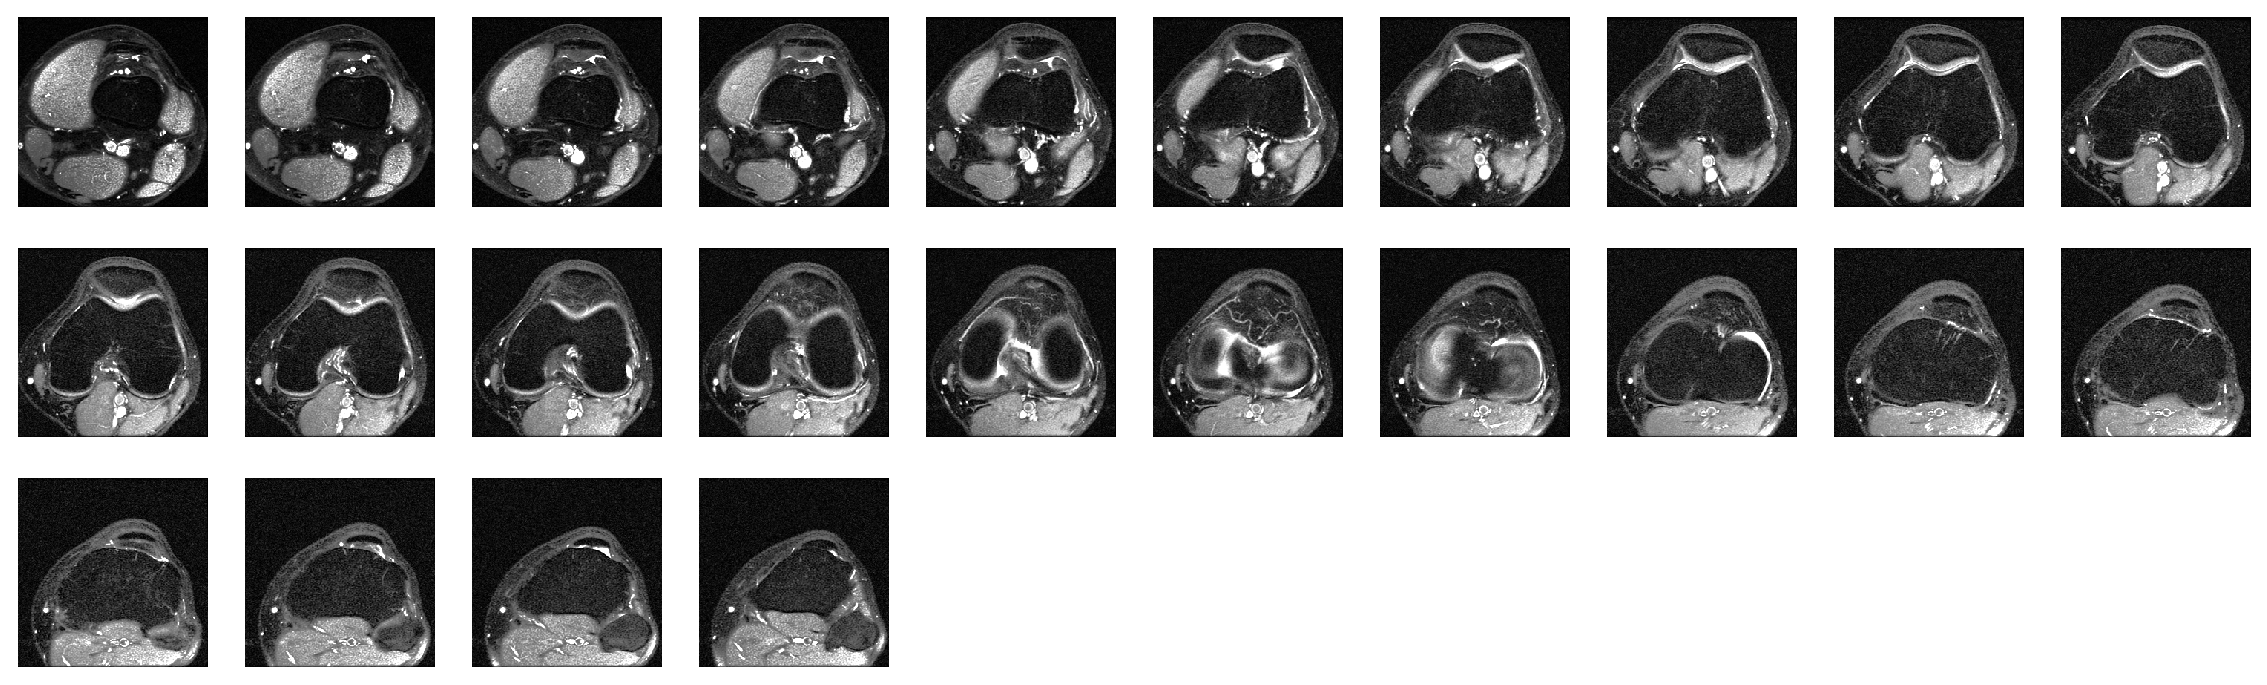

In [9]:
plot_series(train_axial_exams[1])

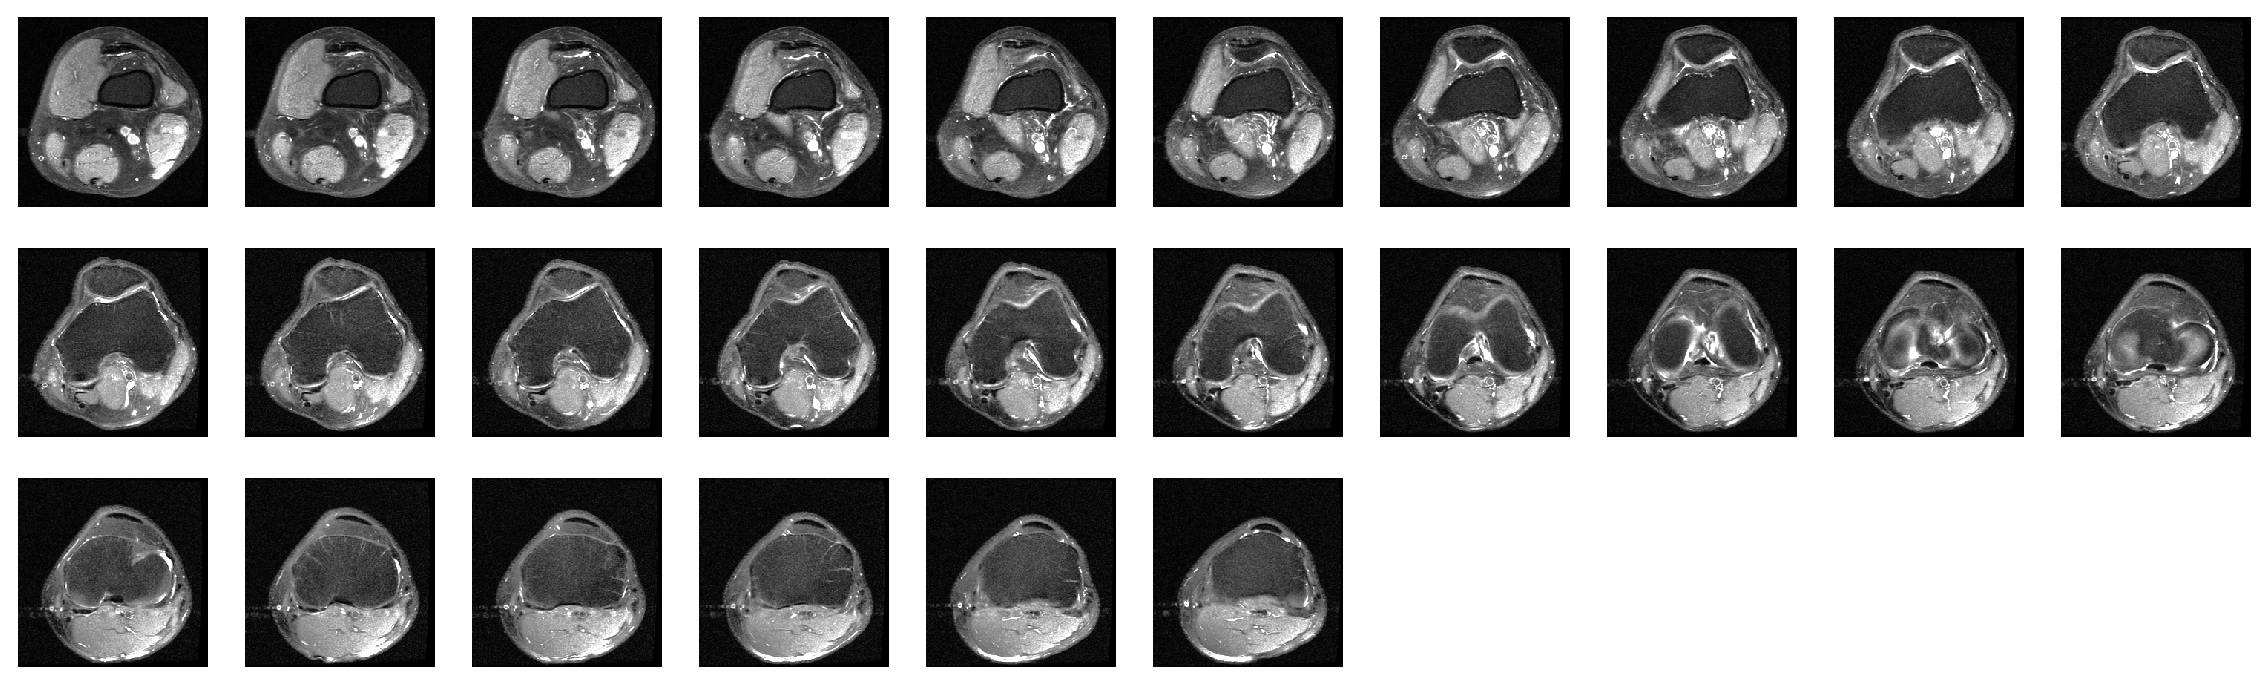

In [10]:
plot_series(train_axial_exams[2])

The number of series in each exams varies, so let's have a look at the distribution of the number of images per exam series.

In [11]:
def get_num_images_per_exam(exams):
    num_images_per_exam = []
    
    for exam in exams:
        series = np.load(exam)
        num_images_per_exam.append(series.shape[0])
        
    return np.asarray(num_images_per_exam)

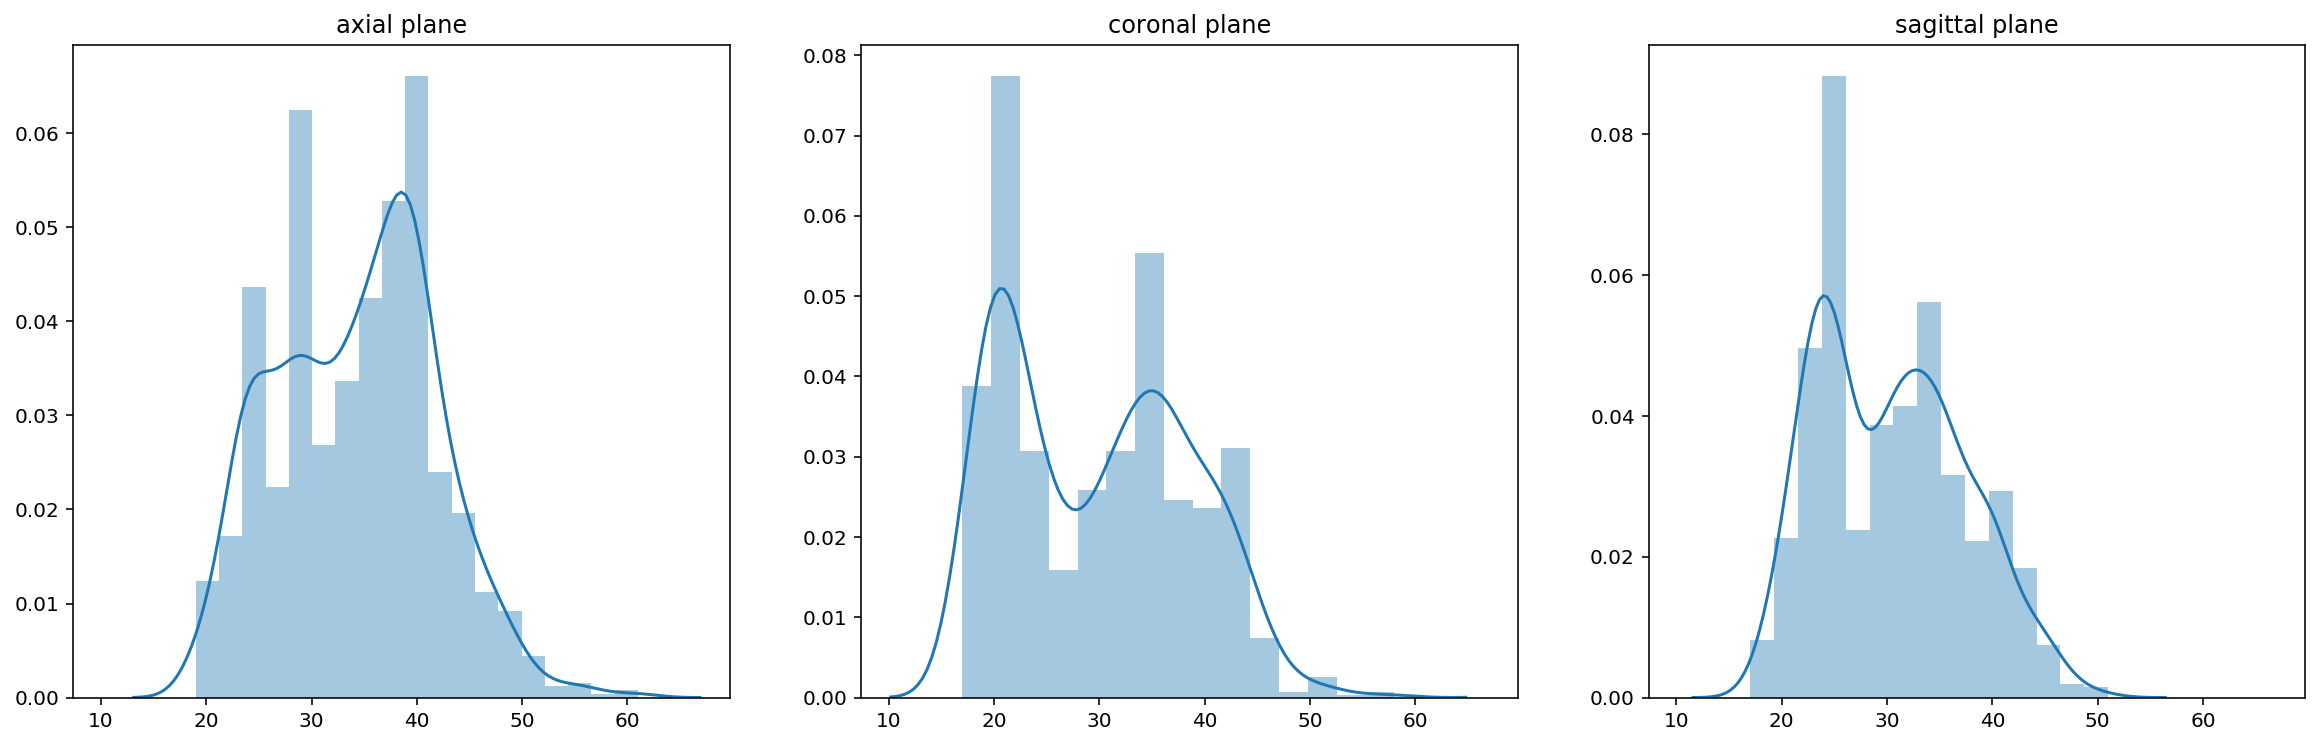

In [12]:
f, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True)

for i, plane in enumerate(planes):
    paths = glob(f'{train_dir}/{plane}/*.npy')
    num_images = get_num_images_per_exam(paths)
    
    sns.distplot(num_images, ax=axes[i])
    axes[i].set_title(f'{plane} plane')

The majority of the cases, the number of images fall in between 20 and 40.

It's probably a good place to stop for now, as we've gained a good understanding of the MRI scan images.

Let's move on and check out the `csv` files next.

## csv files

---

In [13]:
!ls $data_dir/*.csv

data/MRNet-v1.0/train-abnormal.csv  data/MRNet-v1.0/valid-abnormal.csv
data/MRNet-v1.0/train-acl.csv	    data/MRNet-v1.0/valid-acl.csv
data/MRNet-v1.0/train-meniscus.csv  data/MRNet-v1.0/valid-meniscus.csv


In [14]:
train_abnormal_df = pd.read_csv(f'{data_dir}/train-abnormal.csv',
                                header=None,
                                names=['case', 'abnormal'],
                                dtype={'case': str, 'abnormal': np.int64})
print(train_abnormal_df.groupby('abnormal').count())
print('\nMissing values: ', train_abnormal_df.isnull().values.any())
train_abnormal_df.head()

          case
abnormal      
0          217
1          913

Missing values:  False


,case,abnormal
0,0000,1
1,0001,1
2,0002,1
3,0003,1
4,0004,1


In [15]:
train_acl_df = pd.read_csv(f'{data_dir}/train-acl.csv',
                           header=None,
                           names=['case', 'acl'],
                           dtype={'case': str, 'acl': np.int64})
print(train_acl_df.groupby('acl').count())
print('\nMissing values: ', train_acl_df.isnull().values.any())
train_acl_df.head()

     case
acl      
0     922
1     208

Missing values:  False


,case,acl
0,0000,0
1,0001,1
2,0002,0
3,0003,0
4,0004,0


In [16]:
train_meniscus_df = pd.read_csv(f'{data_dir}/train-meniscus.csv',
                                header=None,
                                names=['case', 'meniscus'],
                                dtype={'case': str, 'meniscus': np.int64})
print(train_meniscus_df.groupby('meniscus').count())
print('\nMissing values: ', train_meniscus_df.isnull().values.any())
train_meniscus_df.head()

          case
meniscus      
0          733
1          397

Missing values:  False


,case,meniscus
0,0000,0
1,0001,1
2,0002,0
3,0003,1
4,0004,0


It would be handy to have labels for each diagnosis per case in one place, so we will merge three dataframes.

In [17]:
train_df = pd.merge(train_abnormal_df, train_acl_df, on='case').merge(train_meniscus_df, on='case')
train_df.head()

,case,abnormal,acl,meniscus
0,0000,1,0,0
1,0001,1,1,1
2,0002,1,0,0
3,0003,1,0,1
4,0004,1,0,0


We will do the same for `valid` `csv` files, and save these dataframes as csv files for when we create custom datasets.

In [18]:
valid_abnormal_df = pd.read_csv(f'{data_dir}/valid-abnormal.csv',
                                header=None,
                                names=['case', 'abnormal'],
                                dtype={'case': str, 'abnormal': np.int64})

valid_acl_df = pd.read_csv(f'{data_dir}/valid-acl.csv',
                           header=None,
                           names=['case', 'acl'],
                           dtype={'case': str, 'acl': np.int64})

valid_meniscus_df = pd.read_csv(f'{data_dir}/valid-meniscus.csv',
                                header=None,
                                names=['case', 'meniscus'],
                                dtype={'case': str, 'meniscus': np.int64})

valid_df = pd.merge(valid_abnormal_df, valid_acl_df, on='case').merge(valid_meniscus_df, on='case')
valid_df.head()

,case,abnormal,acl,meniscus
0,1130,0,0,0
1,1131,0,0,0
2,1132,0,0,0
3,1133,0,0,0
4,1134,0,0,0


In [19]:
train_df.to_csv(f'{data_dir}/train_labels.csv')
valid_df.to_csv(f'{data_dir}/valid_labels.csv')

## Co-occurence

---

We can now inspect co-occurence of these three conditions.

In [20]:
pd.options.display.float_format = '{:,.1f}'.format

train_co_occurency_df = train_df.groupby(['abnormal', 'acl', 'meniscus']).count()
train_co_occurency_df['%_freq'] = (train_co_occurency_df.case / train_co_occurency_df.case.sum()) * 100
train_co_occurency_df.head()

case  %_freq
abnormal acl meniscus              
0        0   0          217    19.2
1        0   0          433    38.3
             1          272    24.1
         1   0           83     7.3
             1          125    11.1

In [21]:
valid_co_occurency_df = valid_df.groupby(['abnormal', 'acl', 'meniscus']).count()
valid_co_occurency_df['%_freq'] = (valid_co_occurency_df.case / valid_co_occurency_df.case.sum()) * 100
valid_co_occurency_df.head()

case  %_freq
abnormal acl meniscus              
0        0   0           25    20.8
1        0   0           20    16.7
             1           21    17.5
         1   0           23    19.2
             1           31    25.8

It's worth noting that there's a descrepancy between the `train` and `valid` datasets in terms of the frequency of co-occurence of these conditions.

- Negative of all three
    - train: 19.2%
    - valid: 20.8%


- Abnormal, but no ACL tear and no maniscus tear
    - train: 38.3%
    - valid: 16.7%


- Abnormal with ACL tear, but no maniscus tear
    - train: 7.3%
    - valid: 19.2%


- Abnormal with maniscus tear, but no ACL tear
    - train: 24.1%
    - valid: 17.5%


- Positive of all three
    - train: 11.1%
    - valid: 25.8%